In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#Polynomial Chaos E. terms ----------------------------------------------
def hermite(x,n):
    if n==0:
        return 1
    elif n==1:
        return x
    elif n==2:
        return (x**2-1)/(np.sqrt(2))
    elif n==3:
        return (x**3-3*x)/(np.sqrt(6))
    elif n==4:
        return (x**4-6*x**2+3)/(np.sqrt(24))
    elif n==5:
        return (x**5-10*x**3+15*x)/(np.sqrt(120))

def legendre(x,n):
    if n==0:
        return 1
    elif n==1:
        return x*(np.sqrt(3))
    elif n==2:
        return (3*x**2-1)*(np.sqrt(5))/2
    elif n==3:
        return (5*x**3-3*x)*(np.sqrt(7))/2
    elif n==4:
        return (35*x**4-30*x**2+3)*(np.sqrt(9))/8
    elif n==5:
        return (63*x**5-70*x**3+15*x)*(np.sqrt(11))/8  
    
def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

def PCE(x1,x2,x3,alpha,Y_):
    M_= 0
        
    for j in range (0,len(alpha)):
           
        M_ = M_ + Y_[j] * M1(x1,alpha[j,0]) * M2(x2,alpha[j,1]) * M3(x3,alpha[j,2])  # M(i) can be legendre or hermite

    return M_
#Kriging ----------------------------------------------

def distance1D(x,xk):
    return x.reshape(-1,1)-xk.reshape(1,-1)

def distance(x,xk):                        #multidimensional distance between 2 samples
    d=np.zeros((len(x),len(xk)))
    
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j]+np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

def euclid(r,l,scale):   #using kernell squared Euclidean distance
    return scale*np.exp(-((r**2)/(2*l**2)))

def GaussianPred(x,xn,yn,phi,Y,l,sig):
    
    cov_nn = euclid(distance(xn,xn),l,sig)             #covariance between observations
    cov_xn = euclid(distance(x,xn),l,sig)              #covariance with new points
    cov_mult=np.matmul(cov_xn,np.linalg.inv(cov_nn))   #  r'(x) * R^-1
    #--------------------------------------------------------------------------------------    
    mean=np.matmul(cov_mult,(yn-np.matmul(phi,Y)))     #mean corrected by PCE
    #-------------------------------------------------------------------------------------- 
    cov_xx=euclid(distance(x,x),l,sig)
    variance=np.subtract(cov_xx,np.matmul(cov_mult,cov_xn.transpose())) 
    variaDiag=np.diagonal(variance)
    
    return [mean,variaDiag];

def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
    dist=abs(distance(x,xn))
    voro=np.argmin(np.squeeze(dist))
    return voro

Function to evaluate

In [3]:
def function(x1,x2,x3):
#     return x**0.5*np.sin(x)
#     return -(np.sin(x1*7)+np.cos(14*x2))*(x1**2)*np.exp(-4*x2)
    return 1- (x1**2 + x2**2 + x3**2)

In [4]:
dim=3           # dimensionality
n=35          # observations

np.random.seed(0)         #fixing seed for random number 

#-----------------------------------------------------random Variable 1
x1 = np.random.uniform(-1,1,n)    #uniform
x1min = 0                           #lower bound    
x1max = 1.5                         #upper bound
x1r = scalelegendre(x1,x1min,x1max)
M1=legendre
#-----------------------------------------------------random Variable 2
x2=np.random.normal(0,1,n)  #normal
x2mean= 0.7                          #mean 
x2sigma= 0.3                         #standard deviation
x2r=scalehermite(x2,x2mean,x2sigma)
M2=hermite
#-----------------------------------------------------random Variable 3
x3=np.random.normal(0,1,n)  #normal
x3mean= 1.2                          #mean 
x3sigma= 0.8                         #standard deviation
x3r=scalehermite(x3,x3mean,x3sigma)
M3=hermite
#=====================================================
#=====================================================
y=function(x1r,x2r,x3r)          #Observations

In [5]:
#truncation term
p = 4   #for each variable → same truncation , degree of expansion

indices = np.arange(0,p+1)

A1 = np.zeros((n, p+1))
A2 = np.zeros((n, p+1))
A3 = np.zeros((n, p+1))

comb = np.zeros((p**dim,dim))

#generation of all orthogonal polynomials with degree smaller than p for each variable

for i in range (0,n):
    for j in range (0,p+1):
        A1[i,j] = np.array([M1(x1[i],j)])

for i in range (0,n):
    for j in range (0,p+1):
        A2[i,j] = np.array([M2(x2[i],j)])

for i in range (0,n):
    for j in range (0,p+1):
        A3[i,j] = np.array([M3(x3[i],j)])
#------------------------------------------------------------------------- #all combination of indices

comb = np.array(np.meshgrid(indices,indices,indices)).T.reshape(-1,dim)    

alpha = []

for i in range (0,len(comb)):    #all indices smaller or equal to "p" (truncation term)
    if (np.sum(comb[i]))<=p:  
        alpha.append(comb[i])
        
alpha = np.array(alpha) #alpha for multivariate combination

#combination of multivariate polynomials with degree smaller or equal than "p"

phi = np.zeros((n, len(alpha)))

for i in range (0,n):
    for j in range (0,len(alpha)):
        phi[i,j]=A1[i,alpha[j,0]]*A2[i,alpha[j,1]]*A3[i,alpha[j,2]]
        
#Learning coefficients by Least-Square Minimization

phi_trans=phi.transpose()
phi_Inv=np.linalg.inv(np.matmul(phi_trans, phi))
Inv_phi_trans=np.matmul(phi_Inv,phi_trans)
Y_=np.matmul(Inv_phi_trans,y)     #coefficients for PC =f(M) observations

6.945203979658831e-16


<IPython.core.display.Javascript object>


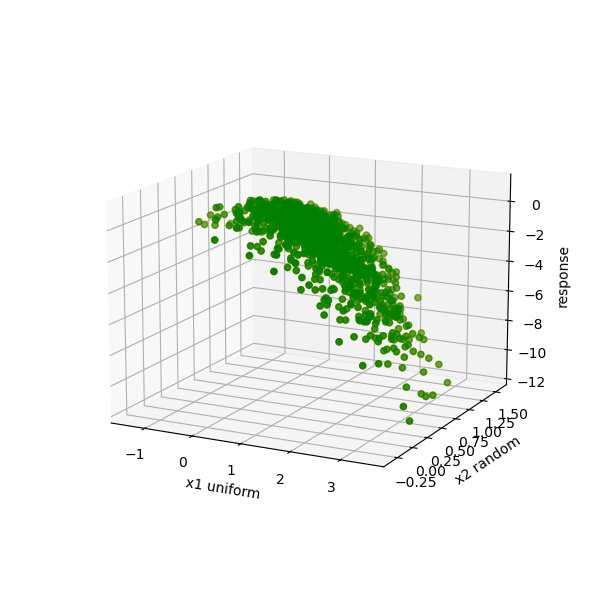

Text(0.5, 0, 'response')

In [6]:
ntest=1000
X1=np.random.uniform(-1,1,ntest)
X2=np.random.normal(0,1,ntest)
X3=np.random.normal(0,1,ntest)

X1leg=scalelegendre(X1,x1min,x1max)
X2her=scalehermite(X2,x2mean,x2sigma)
X3her=scalehermite(X3,x3mean,x3sigma)

Mtest=function(X1leg,X2her,X3her)

M=PCE(X1,X2,X3,alpha,Y_)                      #predictions on calibrated Y_ coefficients

MSE=np.sum((Mtest-M)**2)
print(MSE)

%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3her,X2her,Mtest, color='green')
# ax.scatter(x1r,x2r,y, 'r')
ax.scatter(X3her,X2her,M, color='orange') 
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')